# Ideas on Serial Path Discovering (Jan 14)

This is the continuation of 2010-01-12-jgil-Ideas.

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd

import sys
sys.path.append("../../")
from src.models.synthetic_logs import *

## Functions

In [2]:
def get_successor_pairs_by_freq( traces, sensitivity=-1 ):
    pairs_by_freq = {}

    for trace in traces:
        for pair in get_successor_pairs(trace):
            if pair in pairs_by_freq.keys():
                pairs_by_freq[pair] = pairs_by_freq[pair] + 1
            else:
                pairs_by_freq[pair] = 1
    return pairs_by_freq

In [3]:
def get_successor_pairs( this_trace ):
    pairs = []
    for idx in range(0, len(this_trace)-1):
        partial_subtrace = this_trace[idx:]

        # For every s_i in s_0...s_i...partial_subtrace
        s_i = partial_subtrace.pop(0)
        # Find first K+1 such s_i == s_(k+1)
        try:
            k_plus_1 = partial_subtrace.index(s_i)
        except:
            k_plus_1 = len(partial_subtrace)
        # This is the subtrace T, the maximal that not contains s0
        T=partial_subtrace[:k_plus_1]

        # Collect all (s_i, s_k) with i < k < k+1:
        for s_k in T:
            e = (s_i, s_k)
            pairs.append(e)
    return pairs

In [4]:
def cluster_same_freq(pairs_dic, threshold=0):
    freq = list(set(pairs_dic.values()))
    
    groups = {}
    for pair in pairs_dic.keys():
        f  = pairs_dic[pair]
        if f in groups.keys():
            groups[f].append( pair )
        else:
            groups[f] = [ pair ]
            
    return groups

In [5]:
def get_serial_paths( data, minfreq=0, minsymbols=4):
    if len(data) == 0:
        return []
    
    # Case: pairs
    elif type(data[0]) == type((1,1)):
        pairs = data
        paths = []

        G = nx.DiGraph()
        G.add_edges_from( pairs )

        # Search cliques
        G_prime=nx.to_undirected(G) 
        for V in nx.algorithms.clique.find_cliques(G_prime):
            if len(V) > CLIQUE_THRESHOLD:

                # Create complete graph from clique
                G_complete = G.copy()
                for node in set(G_complete.nodes).difference( set(V) ):
                    G_complete.remove_node(node)

                # Order nodes by outer degree
                nodes = sorted( G_complete.out_degree() , key=lambda p: p[1], reverse=True)
                
                # Strict checking of outer_degree
                i=len(nodes)
                put = True
                for a, outdeg in nodes:
                    i -= 1
                    if outdeg != i:
                        put = False
                if put:
                    paths.append ( [ a for a,b in nodes ] )
        return paths
    
    
    # Case: set of traces
#     elif type(data[0]) == type([]):
#         print( len(data))
#         combined = []
#         for trace in data:
#             combined = combined + get_successor_pairs(trace)
            
#         print(len(combined))
#         return get_serial_paths(combined)

    elif type(data[0]) == type([]):
        cluster = cluster_same_freq( get_successor_pairs_by_freq(data) )
        paths = {}
        for f in cluster.keys():
            if f >= minfreq:
                p = []
                for X in get_serial_paths( cluster[f] ):
                    if len(X) >= minsymbols:
                        p.append(X)
                if len(p) > 0:
                    paths[f] = p
        return paths

## Succesor pairs

Given $ N $ finite integer and a trace $T=s_0 ... s_i ... s_k ... s_j ... s_N$, count $s_i$ get successors pairs with the form $(s_i, s_k)$  such that $0 \le i < k \le j \le N$ and with $j$ maximal such that holds $s_k \neq s_i$. Those pairs preserves the order of appearance and discards loops by construction.

### Examples

In [6]:
get_successor_pairs(list("A"))

[]

In [7]:
get_successor_pairs(list("AB"))

[('A', 'B')]

In [48]:
get_successor_pairs(list("ABCD"))

[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]

In [9]:
get_successor_pairs(list("ABCABCABC"))

[('A', 'B'),
 ('A', 'C'),
 ('B', 'C'),
 ('B', 'A'),
 ('C', 'A'),
 ('C', 'B'),
 ('A', 'B'),
 ('A', 'C'),
 ('B', 'C'),
 ('B', 'A'),
 ('C', 'A'),
 ('C', 'B'),
 ('A', 'B'),
 ('A', 'C'),
 ('B', 'C')]

### Succesors pairs in a trace

If given a set of traces $\overline{T} = \{T_0, ...., T_M\}$, is useful to have the successor combining all the traces and separate them by its frequency of apparition.

Note that this is *not* equivalent to have all the traces concatenated, because some extra pairs will appear in the concatenation. 

In [52]:
T = [
    list("ABC"),
    list("ABCABC"),
]
get_successor_pairs_by_freq(T)

{('A', 'B'): 3,
 ('A', 'C'): 3,
 ('B', 'C'): 3,
 ('B', 'A'): 1,
 ('C', 'A'): 1,
 ('C', 'B'): 1}

Another view of this data is to have the successor pairs grouped by frecuency

In [11]:
cluster_same_freq( get_successor_pairs_by_freq(T) )

{5: [('A', 'B'), ('A', 'C'), ('B', 'C')],
 3: [('B', 'A'), ('C', 'A')],
 1: [('B', 'D'), ('C', 'D'), ('A', 'D')],
 2: [('C', 'B')]}

## Equivalent Graph of Serial Path representation

If we assume that the traces are complete in the sense that it contains entire serial paths, then a directed graph can be constructed $G_{freq}=(V_{freq},E_{freq})$ with all successor pairs $E_{freq}$ of the same frequency group, and vertex set $v \in V_{freq}$ iff $ (u, v) \in E_{freq}$ or $(v, u) \in E_{freq}$ for some  $u \in V_{freq}$. By construction of successor pairs it's true that: 

i) the path $S=s_1...s_L$ of length $L$ exists in $G_{freq}$, 

ii) if $(s_i, s_{i+1}), (s_j, s_{j+1}) \in S$ from some $0 \le i < j \le L$, then $(s_i, s_j), (s_i, s_{j+1}), (s_{i+1}, s_j), (s_{i+1}, s_{j+1}) \in E_{freq}$  

iii) Any subset of vertex of $S$ is also a valid path, then the goal is to search the **maximal** serial path $S$ sharing the same nodes. 

From *ii)* it follows that the equivalent undirected graph $G'_{freq}=(V,E)$ is complete. To reconstruct $S$, the *outer degree* of each node (how many edges goes from node) can be used: $outdeg(s_i) < outdeg(s_j)$ for all $0 \le i < j \le L$.

For example, the path ```ABCD``` forms the following pairs

In [12]:
G = nx.DiGraph()
G.add_edges_from( get_successor_pairs(list("ABCD")) )

In [13]:
G.edges()

OutEdgeView([('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')])

The following images shows a progression of graphs with different size

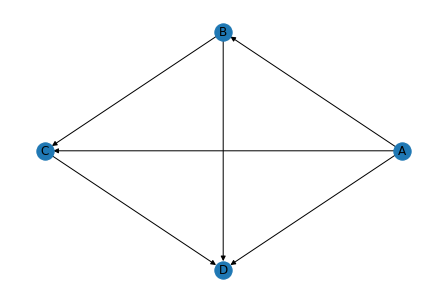

In [14]:
G = nx.DiGraph()
G.add_edges_from( get_successor_pairs(list("ABCD")) )
nx.draw_circular(G, with_labels=True)

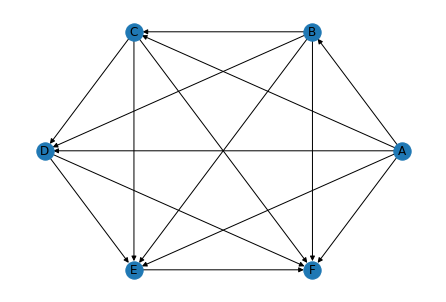

In [15]:
G = nx.DiGraph()
G.add_edges_from( get_successor_pairs(list("ABCDEF")) )
nx.draw_circular(G, with_labels=True)

## Extending Graph

Be $G=(V,E)$ a graph containing $G_{freq}$, i.e. with $V_{freq} \subset V, E_{freq} \subset E$. Given the fact that $G'_{freq}$ is complete, it follows that the undirected graph $G'=(V,E)$ has at least one **clique** of size $|V_{freq}|$ made by $V_{freq}$. And from *iii)* above, the cliques must be maximal.

(See https://en.wikipedia.org/wiki/Clique_(graph_theory) and https://www.geeksforgeeks.org/operations-on-graph-and-special-graphs-using-networkx-module-python/ )

### Example: few extra edges

In the examples below, a CLIQUE_THRESHOLD is set to avoid subgraphs composed by a single edge.

In [16]:
CLIQUE_THRESHOLD=2

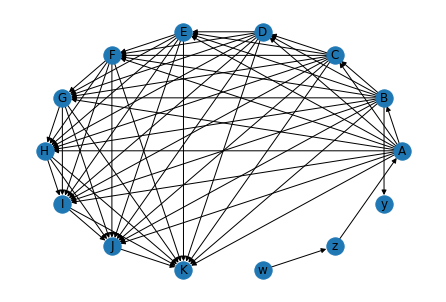

In [17]:
S = list("ABCDEFGHIJK")
S_pairs = get_successor_pairs(S) + [ ("w", "z"), ("B", "y"), ("z", "A") ] 

G = nx.DiGraph()
G.add_edges_from( S_pairs )
nx.draw_circular(G, with_labels=True)

size= 11: ['A', 'G', 'J', 'C', 'B', 'F', 'K', 'D', 'I', 'E', 'H']
[('A', 10), ('B', 9), ('C', 8), ('D', 7), ('E', 6), ('F', 5), ('G', 4), ('H', 3), ('I', 2), ('J', 1), ('K', 0)]
ABCDEFGHIJK


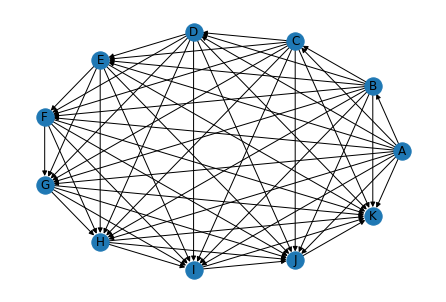

In [18]:
V_unordered = []

# Search cliques
G_prime=nx.to_undirected(G) 
for i in nx.algorithms.clique.find_cliques(G_prime):
    if len(i) > CLIQUE_THRESHOLD:
        print( "size=%3d: %s" %(len(i), i))
        V_unordered.append(i)

# Iterate over cliques
for V in V_unordered:
    
    # Create complete graph from clique
    G_complete = G.copy()
    for node in set(G_complete.nodes).difference( set(V) ):
        G_complete.remove_node(node)
    nodes = sorted( G_complete.out_degree() , key=lambda p: p[1], reverse=True)
    print(nodes)
    S_reconstructed = [ a for a,b in nodes ]

    print( "".join(S_reconstructed) )
    nx.draw_circular(G_complete, with_labels=True)

In [19]:
# Same functionality with a function
pairs = get_successor_pairs(list("ABCDEFGHIJK")) + [ ("w", "z"), ("B", "y"), ("z", "A") ] 
get_serial_paths( pairs )

[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']]

### Example: random tails

In [20]:
T = [
    list("ABCD1"),
    list("ABCD12"),
    list("ABCD23"),
    list("ABCD1268"),
    list("ABCD841"),
]
get_serial_paths( T, minfreq=1 )

{5: [['A', 'B', 'C', 'D']]}

### Example: random noise

In [21]:
T = [
    list("A1B2CDE"),
    list("2AB1CDE"),
    list("3AB5CD9E"),
    list("ABCDE7"),
    list("A1BC8DE1"),
]
get_serial_paths( T, minfreq=1 )

{5: [['A', 'B', 'C', 'D', 'E']],
 1: [['3', 'A', '5', '9'],
  ['3', '5', 'C', '9'],
  ['3', 'B', '5', '9'],
  ['3', '5', 'D', '9'],
  ['3', '5', '9', 'E']]}

In [22]:
get_serial_paths( T, minfreq=2 )

{5: [['A', 'B', 'C', 'D', 'E']]}

### Example: similar paths (if then)

*Emerging property*... this resembles the if-then cycle

In [23]:
T = [
    list("ABCDE01234"),
    
    list("ABCDE5678")
]
get_serial_paths( T, minfreq=1 )

{2: [['A', 'B', 'C', 'D', 'E']],
 1: [['A', '5', '6', '7', '8'],
  ['C', '5', '6', '7', '8'],
  ['B', '5', '6', '7', '8'],
  ['D', '5', '6', '7', '8'],
  ['E', '5', '6', '7', '8'],
  ['A', '0', '1', '2', '3', '4'],
  ['C', '0', '1', '2', '3', '4'],
  ['B', '0', '1', '2', '3', '4'],
  ['D', '0', '1', '2', '3', '4'],
  ['E', '0', '1', '2', '3', '4']]}

In [24]:
T = [
    list("ABCDE01234"),
    list("ABCDE01234"),
    
    list("ABCDE5678"),
    list("ABCDE5678")
]
get_serial_paths( T, minfreq=1 )

{4: [['A', 'B', 'C', 'D', 'E']],
 2: [['A', '5', '6', '7', '8'],
  ['C', '5', '6', '7', '8'],
  ['B', '5', '6', '7', '8'],
  ['D', '5', '6', '7', '8'],
  ['E', '5', '6', '7', '8'],
  ['A', '0', '1', '2', '3', '4'],
  ['C', '0', '1', '2', '3', '4'],
  ['B', '0', '1', '2', '3', '4'],
  ['D', '0', '1', '2', '3', '4'],
  ['E', '0', '1', '2', '3', '4']]}

In [25]:
T = [
    list("ABCDE01234"),
    list("ABCDE01234"),
    list("ABCDE01234"),
    
    list("ABCDE5678"),
    list("ABCDE5678"),
    list("ABCDE5678")
]
get_serial_paths( T, minfreq=1 )

{6: [['A', 'B', 'C', 'D', 'E']],
 3: [['A', '5', '6', '7', '8'],
  ['C', '5', '6', '7', '8'],
  ['B', '5', '6', '7', '8'],
  ['D', '5', '6', '7', '8'],
  ['E', '5', '6', '7', '8'],
  ['A', '0', '1', '2', '3', '4'],
  ['C', '0', '1', '2', '3', '4'],
  ['B', '0', '1', '2', '3', '4'],
  ['D', '0', '1', '2', '3', '4'],
  ['E', '0', '1', '2', '3', '4']]}

In [26]:
T = [
    list("ABCDE01234"),
    list("ABCDE01234"),
    list("ABCDE01234"),
    list("ABCDE01234"),
    
    list("ABCDE5678"),
    list("ABCDE5678")
]
get_serial_paths( T, minfreq=1 )

{6: [['A', 'B', 'C', 'D', 'E']],
 4: [['A', '0', '1', '2', '3', '4'],
  ['C', '0', '1', '2', '3', '4'],
  ['B', '0', '1', '2', '3', '4'],
  ['D', '0', '1', '2', '3', '4'],
  ['E', '0', '1', '2', '3', '4']],
 2: [['A', '5', '6', '7', '8'],
  ['C', '5', '6', '7', '8'],
  ['B', '5', '6', '7', '8'],
  ['D', '5', '6', '7', '8'],
  ['E', '5', '6', '7', '8']]}

In [27]:
T = [
    list("ABCDE01234"),
    list("ABCDE01234"),
    list("ABCDE01234"),
    list("ABCDE01234"),
    list("ABCDE01234"),

    list("ABCDE5678")
]
get_serial_paths( T, minfreq=1 )

{6: [['A', 'B', 'C', 'D', 'E']],
 5: [['A', '0', '1', '2', '3', '4'],
  ['C', '0', '1', '2', '3', '4'],
  ['B', '0', '1', '2', '3', '4'],
  ['D', '0', '1', '2', '3', '4'],
  ['E', '0', '1', '2', '3', '4']],
 1: [['A', '5', '6', '7', '8'],
  ['C', '5', '6', '7', '8'],
  ['B', '5', '6', '7', '8'],
  ['D', '5', '6', '7', '8'],
  ['E', '5', '6', '7', '8']]}

In [28]:
T = [
    list("ABC123456"),
    list("ABC123456"),

    list("ABC123789"),
    list("ABC123789"),

    list("ABCWXYZ"),
    list("ABCWXYZ"),
]
get_serial_paths( T, minfreq=1 )

{4: [['C', '1', '2', '3'], ['B', '1', '2', '3'], ['A', '1', '2', '3']],
 2: [['3', '4', '5', '6'],
  ['3', '7', '8', '9'],
  ['1', '4', '5', '6'],
  ['1', '7', '8', '9'],
  ['2', '4', '5', '6'],
  ['2', '7', '8', '9'],
  ['A', '4', '5', '6'],
  ['A', 'W', 'X', 'Y', 'Z'],
  ['A', '7', '8', '9'],
  ['C', '4', '5', '6'],
  ['C', 'W', 'X', 'Y', 'Z'],
  ['C', '7', '8', '9'],
  ['B', '4', '5', '6'],
  ['B', 'W', 'X', 'Y', 'Z'],
  ['B', '7', '8', '9']]}

### Example: repeated traces (loops)

Strange example... with repetitions in the same trace the serial path appears inverted ```DCBA``` ... **did I found loops by mistake??**

In [29]:
T = [
    list("ABCD"),
    list("ABCDABCD"),
    list("ABCDABCDABCD"),
    list("EFGHI"),
    list("EFGHIABCD"),
    list("EFGHIEFGHIEFGHIEFGHI"),
]
get_serial_paths( T, minfreq=2 )

{7: [['A', 'B', 'C', 'D']],
 3: [['I', 'H', 'G', 'F', 'E'], ['D', 'C', 'B', 'A']],
 6: [['E', 'F', 'G', 'H', 'I']]}

## Dataset play

### Serial with some noise

In [30]:
logs = synthetic_logs()
logs.add( noisy_path( every=10, num_symbols=10, count=20)  )
logs.add( serial_path( size=7, every=25, error=5, probability=1)  )

instances = logs.generate_instances(100)
logs.show_instances(3)

  1 : [h A e a e B g e C g d j D h g E d f a F c i G a j g f]
  2 : [i A i j f B b d f C e e D j e E j c g F h e d G b i a]
  3 : [a A g f B f d C f c D a g c E j j F b c e G g d c c j]


In [31]:
pd.DataFrame(logs.describe()['generators'])

,class,#symbols,example,error,probability
0,noisy_path,10,f f b e c b d c f j,NaN,NaN
1,serial_path,7,A B C D E F G,5.0,1.0


In [32]:
traces = [ [ s for (t, s) in serie ] for serie in instances ]  
get_serial_paths( traces, minfreq= 5 )

{100: [['A', 'B', 'C', 'D', 'E', 'F', 'G']]}

### Shuffled serials, equal appearance

In [33]:
# Very unordered series has... far better results!!
logs = synthetic_logs()
logs.add( serial_path( size=7, every=25, error=15, probability=1)  )
logs.add( serial_path( size=7, every=25, error=15, probability=1)  )

instances = logs.generate_instances(100)
logs.show_instances(5)

  1 : [H A I B J C K D L E F M N G]
  2 : [H A B I C J K D L M E N F G]
  3 : [A H B I C D J K E F L M N G]
  4 : [A H B I C D J E K F L G M N]
  5 : [A H I B C J K L D M E F N G]


In [34]:
pd.DataFrame(logs.describe()['generators'])

,class,#symbols,example,error,probability
0,serial_path,7,A B C D E F G,15,1
1,serial_path,7,H I J K L M N,15,1


In [35]:
traces = [ [ s for (t, s) in serie ] for serie in instances ]  
get_serial_paths( traces, minfreq=5 )

{100: [['H', 'C', 'D', 'M', 'N'],
  ['H', 'C', 'D', 'E', 'F', 'G'],
  ['H', 'C', 'L', 'M', 'N'],
  ['H', 'I', 'J', 'E', 'F', 'G'],
  ['H', 'I', 'J', 'K', 'L', 'M', 'N'],
  ['H', 'I', 'J', 'K', 'G'],
  ['H', 'I', 'D', 'M', 'N'],
  ['H', 'I', 'D', 'E', 'F', 'G'],
  ['A', 'I', 'J', 'E', 'F', 'G'],
  ['A', 'I', 'J', 'K', 'L', 'M', 'N'],
  ['A', 'I', 'J', 'K', 'G'],
  ['A', 'I', 'D', 'M', 'N'],
  ['A', 'I', 'D', 'E', 'F', 'G'],
  ['A', 'B', 'C', 'D', 'M', 'N'],
  ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
  ['A', 'B', 'C', 'L', 'M', 'N'],
  ['A', 'B', 'K', 'L', 'M', 'N'],
  ['A', 'B', 'K', 'G']]}

### Merged serials, unbalanced

In [36]:
logs = synthetic_logs()
logs.add( serial_path( size=7, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=7, every=25, error=5, probability=0.9)  )

instances = logs.generate_instances(100)
logs.show_instances(5)

  1 : [A H B I C J D K E L F M G N]
  2 : [A B C D E F G]
  3 : [A H B I C J D K E L F M G N]
  4 : [A B C D E F G]
  5 : [H I J K L M N]


In [37]:
pd.DataFrame(logs.describe()['generators'])

,class,#symbols,example,error,probability
0,serial_path,7,A B C D E F G,5,0.9
1,serial_path,7,H I J K L M N,5,0.9


In [38]:
traces = [ [ s for (t, s) in serie ] for serie in instances ]  
get_serial_paths( traces, minfreq=5 )

{91: [['A', 'B', 'C', 'D', 'E', 'F', 'G']],
 92: [['H', 'I', 'J', 'K', 'L', 'M', 'N']]}

### Merged unbalanced serials plus noise

In [39]:
logs = synthetic_logs()
logs.add( serial_path( size=7, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=7, every=25, error=5, probability=0.9)  )
logs.add( noisy_path( every=10, num_symbols=20, count=25)  )

instances = logs.generate_instances(100)
logs.show_instances(5)

  1 : [b A t l g B d t C p t D n i E d a h F h i G r n d i k l i j m m]
  2 : [r A H j q B b I h j C l J d t D h K e c E f L o F s M q G p k N r s a c k g p]
  3 : [o A H c o B I r d J C o o K d D m L i a E f M h a F N o k n G o j t r f s b b]
  4 : [s H k n I g l J j k K j e t L a c M m h i N l m p o r l n a e l]
  5 : [t H A f o m B I d h J r C r K f D s L f r E M q p F t N b G i g k r s g m t h]


In [40]:
pd.DataFrame(logs.describe()['generators'])

,class,#symbols,example,error,probability
0,serial_path,7,A B C D E F G,5.0,0.9
1,serial_path,7,H I J K L M N,5.0,0.9
2,noisy_path,20,l g k e q q j r a b,NaN,NaN


In [41]:
traces = [ [ s for (t, s) in serie ] for serie in instances ]  
get_serial_paths( traces, minfreq=5 )

{91: [['A', 'B', 'C', 'D', 'E', 'F', 'G']],
 89: [['H', 'I', 'J', 'K', 'L', 'M', 'N']]}

### Several unbalanced serials plus noise

In [42]:
logs = synthetic_logs()
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( noisy_path( every=10, num_symbols=20, count=25)  )

instances = logs.generate_instances(100)
logs.show_instances(5)

  1 : [c K A U AO AE o e B L AF AP n V i C M AG c W AQ t D l X AH N s AR k E O AI h Y d AS F P p AJ Z a Q AT G l AA AK s R AU n H r AB AL t S AV I j AC AM h T p J AW AD o AN t e AX]
  2 : [t U AO A K AE f d V s AP B AF L h e W AQ M i AG C g X AR f D AH N f Y a AS E AI m O a Z AT AJ f F P o AA AK AU m Q e G AL p AB AV R q H j AC AM c AW I S l m AD AN AX b J T k]
  3 : [j K U A AO AE n b L r V AF B AP f q W AG AQ M h C k N AH n D X AR k m E O Y AI j AS t F Z P n AT AJ f d Q G AA AK AU f p R H AB e AL AV e m I S AC AW AM s h AX AD T J AN q b]
  4 : [h AO U AE K c g AP V AF L h p AQ W M o AG n AR X g N AH f c Y AS t AI O s AT Z f AJ P a AU m AA o AK Q j AV AB g AL R p q AC AW q AM S t AD AX g AN k T l]
  5 : [A K c AO U AE j p B V L AF s AP f C t W AG M AQ r D l AH AR b N X r E AI n Y AS O i AJ h F Z e P AT l AK G j Q AA AU g AL p H a AV R AB AM s I o AC AW S g AN J o T AD k AX r]


In [43]:
pd.DataFrame(logs.describe()['generators'])

,class,#symbols,example,error,probability
0,serial_path,10,A B C D E F G H I J,5.0,0.9
1,serial_path,10,K L M N O P Q R S T,5.0,0.9
2,serial_path,10,U V W X Y Z AA AB AC AD,5.0,0.9
3,serial_path,10,AE AF AG AH AI AJ AK AL AM AN,5.0,0.9
4,serial_path,10,AO AP AQ AR AS AT AU AV AW AX,5.0,0.9
5,noisy_path,20,c o b h r g c k b o,NaN,NaN


In [44]:
traces = [ [ s for (t, s) in serie ] for serie in instances ]  
get_serial_paths( traces, minfreq= 5  )

{90: [['K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']],
 88: [['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']],
 92: [['U', 'V', 'W', 'X', 'Y', 'Z', 'AA', 'AB', 'AC', 'AD']],
 93: [['AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX'],
  ['AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN']]}

### serials plus noise, but one with P=1

In [45]:
logs = synthetic_logs()
logs.add( serial_path( size=10, every=25, error=5, probability=1)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( serial_path( size=10, every=25, error=5, probability=0.9)  )
logs.add( noisy_path( every=10, num_symbols=20, count=25)  )

instances = logs.generate_instances(100)
logs.show_instances(5)

  1 : [f AE K U AO A i q AP L AF V i B b AQ r AG M W c C o AH AR X h N g D j O AI Y AS h E j P d Z AT AJ F t q Q l AA AU AK G c R s AL AB p AV H i S AM o AW AC q I e AN T AX h AD J]
  2 : [q K A AE U AO b t V j B L AF AP o W i AG C M l AQ m X AH s D N AR p Y AI p E O m AS t Z AJ h P F k AT AA l Q AK i G AU b AB e R AL H r AV t S AC m I AM AW t T AD o AN J b AX]
  3 : [s A K AE U r n AF V B L k g AG W k C M k AH i X k N D AI t Y p O E AJ m Z h P F n AK a AA Q h G p AL t H R AB g AM g I S d AC n AN J a T AD t h]
  4 : [AE p K A U AO f p AF L B V AP k p M AG m C AQ W i r AH N D AR s X i AI j O E AS Y i p P AT AJ c F Z q h Q AK AU G h AA c c AL H R AV c AB d AM AW s S I AC c AN AX q T J j AD]
  5 : [d AO A K U AE m k AP AF B h L V g AQ AG m W C r M k AH AR b N X D e AI l O AS E Y s AJ d P F AT t Z l AK Q AU q G AA g AL d R AV H d AB r AW AM S b I AC s AN AX p T t J AD r]


In [46]:
pd.DataFrame(logs.describe()['generators'])

,class,#symbols,example,error,probability
0,serial_path,10,A B C D E F G H I J,5.0,1.0
1,serial_path,10,K L M N O P Q R S T,5.0,0.9
2,serial_path,10,U V W X Y Z AA AB AC AD,5.0,0.9
3,serial_path,10,AE AF AG AH AI AJ AK AL AM AN,5.0,0.9
4,serial_path,10,AO AP AQ AR AS AT AU AV AW AX,5.0,0.9
5,noisy_path,20,f s t r s g l m b e,NaN,NaN


In [47]:
traces = [ [ s for (t, s) in serie ] for serie in instances ]  
get_serial_paths( traces, minfreq= int( len(traces) / 10)  )

{89: [['AE', 'AF', 'C', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN'],
  ['AE', 'AF', 'AG', 'AH', 'AI', 'G', 'AM', 'AN'],
  ['AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'H', 'AN'],
  ['AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'J'],
  ['AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN'],
  ['AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'I'],
  ['AE', 'AF', 'AG', 'AH', 'F', 'AL', 'AM', 'AN'],
  ['AE', 'AF', 'AG', 'D', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN'],
  ['AE', 'AF', 'AG', 'E', 'AJ', 'AK', 'AL', 'AM', 'AN'],
  ['A', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN'],
  ['AE', 'B', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN']],
 88: [['K', 'L', 'M', 'D', 'O', 'P', 'Q', 'R', 'S', 'T'],
  ['K', 'B', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T'],
  ['K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'J'],
  ['K', 'L', 'M', 'N', 'O', 'P', 'Q', 'I'],
  ['K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T'],
  ['K', 'L', 'M', 'N', 'O', 'P', 'Q', 'H', 'T'],
  ['K', 'L', 'M', 'N', 'O', 'F', 'Q', 'R', 'S', 'T'],

## Conclusions

1. The algorithm is useful for a len(S) > 3, because the high probability to have the edge set $(s_0, s_1), (s_1, s_2), (s_0, s_1)$, while in contrast, the chances are dramatically lower to have this set in the same frequency range: $(s_0, s_1), (s_1, s_2), (s_2, s_3), (s_0, s_1), (s_0, s_2), (s_0, s_3), (s_1, s_3)$
1. Using cliques, the time to get results is quite low
1. If just one serial path appears, the precision is 100%
1. When several serial paths are in the same dataset, two cases appears. 1) If each path appears in less than 100% of the instances, they are quite well detected. 2) If at least one path is present in all instances, the detection is good for that one but shows several false positives in the others.
1. I developed a powerful sample instance generator.

## Pending tasks

1. Add tolerance to incomplete sequences
1. Test with Observatory logs